## Dataset: Concardia

Concadia is a dataset introduced in our paper and contains Wikipedia images with their respective captions, alt descriptions and the broader context the images are situated in. We use this corpus to argue for a clear distinction between descriptions and captions, and show the similarities and differences between the two text forms. We further argue that captions and broader context are an important resource that can inform the generation of descriptions which are very sparse across the Web but absolutely crucial to make images accessible.

## Dataset: PixSet

The dataset can be used to train models to follow edit instructions. Edit instructions are available in the edit_prompt. original_image can be used with the edit_prompt and edited_image denotes the image after applying the edit_prompt on the original_image.



In [80]:
import pandas as pd
import numpy as np
from typing import *
from matplotlib import pyplot as plt 
from pathlib import Path


In [81]:
def read_meta(file_path:Path|str) -> pd.DataFrame:
    file_path = Path(file_path)
    if not file_path.exists():
        raise FileNotFoundError
    js = pd.read_json(file_path)
    df = pd.json_normalize(js['images'])
    
    return df

def read_parque(dataset_path:Path|str) -> pd.DataFrame:
    dataset_path = Path(dataset_path)
    if not dataset_path.exists():
        raise FileNotFoundError
    
    df = pd.read_parquet(dataset_path, engine='fastparquet')
    return df 


In [82]:
from torch.utils.data import Dataset
from cv2 import imread
from random import randint
class Concadia(Dataset):
    def __init__(self, src_dataset:Path|str, src_meta:Path|str, split:Literal['train','val','test']):
        super().__init__()
        src_dataset = Path(src_dataset)
        if not src_dataset.exists():
            raise FileNotFoundError
        
        self.meta = read_meta(src_meta).query(f"split == '{split}'")
        self.src_dataset = src_dataset

    def __len__(self):
        return self.meta.size
    
    def __getitem__(self, index):
        record = self.meta.iloc[index]
        
        img_path = self.src_dataset.joinpath(record['filename'])
        img = imread(img_path)
       
        return (img, record['description.raw'])
    

class PixSet(Dataset):
    def __init__(self, src_dataset:Path|str,size:int, split:Literal['train','val','test'], offset:int=0):
        super().__init__()
        src_dataset = Path(src_dataset)
        self.offset = offset
        if not src_dataset.exists():
            raise FileNotFoundError
        
        self.ds = load_dataset(path=str(src_dataset), split=f'{split}[{offset}:{size}]')
        
        if offset + size > self.ds.dataset_size:
            raise IndexError
        

    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        record = self.ds[self.offset + index]
        return (record['original_image'], record['original_prompt'], record['edit_prompt'], record['edited_image'], record['edited_prompt'])

        



In [83]:
dataset = PixSet("../../dataset/pixset/", 25_000, "train", offset=0)

In [84]:
print(dataset.__len__())


25000


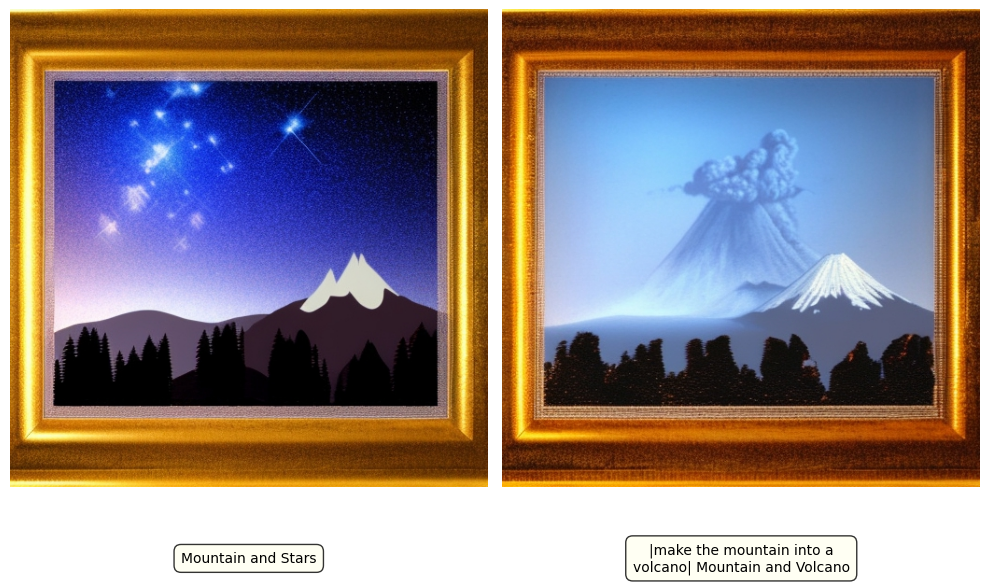

In [89]:
import matplotlib.pyplot as plt
import textwrap

# Assumiamo che 're' sia un dizionario contenente le immagini e le descrizioni.
# Esempio di dati (sostituisci con i tuoi dati reali)
import numpy as np

re = dataset[randint(0, 100)]
# 1. Crea una figura con 1 riga e 2 colonne, leggermente più alta
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Definisci lo stile comune per i box di testo
bbox_props = dict(boxstyle="round,pad=0.5", fc="ivory", ec="black", lw=1, alpha=0.8)

# --- Immagine 1 (Sinistra) ---
axes[0].imshow(re[0])
# Prepara il testo dividendolo su più righe se necessario
wrapped_text_1 = textwrap.fill(re[1], width=30)
# Aggiungi il box di testo al posto del titolo
axes[0].text(0.5, -0.15, wrapped_text_1,
             ha='center', va='center', transform=axes[0].transAxes, bbox=bbox_props)


# --- Immagine 2 (Destra) ---
axes[1].imshow(re[3])
# Prepara il testo dividendolo su più righe se necessario
wrapped_text_2 = "|" + textwrap.fill(re[2] + "|\n" + re[4], width=30)
# Aggiungi il box di testo al posto del titolo
axes[1].text(0.5, -0.15, wrapped_text_2,
             ha='center', va='center', transform=axes[1].transAxes, bbox=bbox_props)


# 4. Rimuovi gli assi per un look pulito
for ax in axes:
    ax.axis('off')

# 5. Ottimizza la disposizione per evitare sovrapposizioni e mostra il plot
plt.tight_layout()
plt.show()